In [1]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
import scipy.optimize
import numpy
import random
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('user_item_playtime.csv')
data = data.sample(n=200000)
data.head(5)

user_id  item_id  playtime_forever
2518970  76561198083585931   224540               166
3899994  76561197998765811    10500              1446
3018910       DeusVultboiz   211740               129
1872507          vonravend     2420                 0
558985        Scorpion1903   234390               457

In [4]:
len(data)

200000

In [5]:
labels = [1 if i>0 else 0 for i in data['playtime_forever']]
sum(labels)/len(labels)

0.63512

In [6]:
def splitData(X, y, p1, p2, balance=False): 
    X = np.array(X)
    y = np.array(y)

    if balance:
        total = len(y)
        n = round(len(y)*p1/2)

        idx = []
        while len(idx) < n:
            i = random.choice(range(total))
            if y[i] == 1:
                idx.append(i)
        X_test = X[idx]
        y_test = y[idx]
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)
        
        idx = []
        total = len(y)
        while len(idx) < n:
            i = random.choice(range(total))
            if y[i] == 0:
                idx.append(i)
        X_test = np.concatenate((X_test,X[idx]), axis=0)
        y_test = np.concatenate((y_test,y[idx]), axis=0)
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)

    else:
        sss = StratifiedShuffleSplit(n_splits=5, test_size=p1)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        X = X_train
        y = y_train

    sss = StratifiedShuffleSplit(n_splits=5, test_size=p2)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

    print(len(y_train), len(y_valid), len(y_test))
    print(sum([len(y_train), len(y_valid), len(y_test)]))
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    

In [7]:
data_train, y_train, data_valid, y_valid, data_test, y_test = splitData(data, labels, .1, .15)

153000 27000 20000
200000


In [8]:
data_train[0]

array(['76561198060758376', 251570, 1179], dtype=object)

### Index:

0:  user_id	
1:  item_id	
2:  play_after_buy	

In [9]:
# idx = []
# X_train = data

In [10]:
def evaluate(y1,y2,detail=False):
    if not detail:
        return accuracy_score(y1,y2), f1_score(y1,y2), 1-balanced_accuracy_score(y1,y2)
    else:
        TN, FP, FN, TP = confusion_matrix(y1,y2).ravel()
        BER = (FP/(TN+FP) + FN/(FN+TP))/2
        PREC = TP/(TP+FP)
        RECALL = TP/(TP+FN)
        F1 = 2*(PREC*RECALL)/(PREC+RECALL)
        Acc = accuracy_score(y1,y2)
        return TN,FP,FN,TP,BER,PREC,RECALL,F1,Acc


In [11]:
timePerUser = defaultdict(list)
timePerItem = defaultdict(list)
for u,i,t in data_train:
    timePerUser[u].append((i,t))
    timePerItem[i].append((u,t))
N = len(data_train)
nUsers = len(timePerUser)
nItems = len(timePerItem)
users = list(timePerUser.keys())
items = list(timePerItem.keys())
alpha = np.mean(y_train)
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

In [12]:
timeByUser = defaultdict(int)
timeByItem = defaultdict(int)
timeUserAvg = 0
timeItemAvg = 0
for usr in users:
    tmp = sum(x[1] for x in timePerUser[usr])/len(timePerUser[usr])
    timeUserAvg = (timeUserAvg+tmp)/2
    timeByUser[usr] = tmp
for item in items:
    tmp = sum(x[1] for x in timePerItem[item])/len(timePerItem[item])
    timeItemAvg = (timeItemAvg+tmp)/2  
    timeByItem[usr] = tmp 

In [13]:
def cleanData(data):
    # review_label, review_avg_emo_per_user, review_avg_emo_per_game
    res = []
    for row in data:
        tmp = []
        if row[0] in timeByUser:
            tmp.append(timeByUser[row[0]])
        else:
            print(row[0],row[1],'user miss!')
            tmp.append(timeUserAvg)
        if row[1] in timeByItem:
            tmp.append(timeByItem[row[1]])
        else:
            print(row[0],row[1],'game miss!')
            tmp.append(timeItemAvg)
        res.append(tmp)
    return res

In [14]:
train_clean = cleanData(data_train)
valid_clean = cleanData(data_valid)
test_clean = cleanData(data_test)

76561198060758376 251570 game miss!
76561198074860147 24860 game miss!
DarksHD 335240 game miss!
76561198026783871 201810 game miss!
76561198059738468 302830 game miss!
ItzJimmeh 34830 game miss!
tafara12 244930 game miss!
76561198090621006 297810 game miss!
speddoman 268650 game miss!
JolteonBro 113420 game miss!
muralsparky 248820 game miss!
SuperM 63200 game miss!
AriakWolf 380 game miss!
argaimess 265930 game miss!
bigprenis 35140 game miss!
Izaiby 63000 game miss!
Ellisayger 1250 game miss!
mokomokoman 355950 game miss!
susanoofag 218620 game miss!
76561198067871080 301640 game miss!
FrostAssassinator 620 game miss!
brandypower 214510 game miss!
SFort 380 game miss!
76561198065880238 113420 game miss!
76561198084063741 207610 game miss!
gehennaa 43110 game miss!
Outbackalien 303470 game miss!
Taeza 346110 game miss!
Write-0ff 94200 game miss!
76561198097581365 33930 game miss!
YoHan103303 235600 game miss!
jarryd187 201280 game miss!
76561197969599867 238460 game miss!
LoveStage 5

In [15]:
train_clean[:5],valid_clean[:5],test_clean[:5]

([[480.6666666666667, 3.7012199121188942],
  [87.5, 3.7012199121188942],
  [238.75, 3.7012199121188942],
  [440.3333333333333, 3.7012199121188942],
  [13.25, 3.7012199121188942]],
 [[159.7585379040999, 3.7012199121188942],
  [455.2, 3.7012199121188942],
  [159.7585379040999, 3.7012199121188942],
  [96.5, 3.7012199121188942],
  [173.4375, 3.7012199121188942]],
 [[850.6, 3.7012199121188942],
  [684.7692307692307, 3.7012199121188942],
  [1369.0, 3.7012199121188942],
  [84.5, 3.7012199121188942],
  [194.7, 3.7012199121188942]])

In [16]:
c_list = [1e-5,1e-3,1e-2,1e-1,1,10]
res1_valid = []
for c in c_list:
    # 记得再考虑 balance！！！！
    reg = linear_model.LogisticRegression(C=c, random_state=0, class_weight='balanced').fit(train_clean, y_train)
    y1_valid = reg.predict(valid_clean)
    acc, F1, BER= evaluate(y_valid,y1_valid)
    res1_valid.append((acc, F1, BER, c))
pd.DataFrame(res1_valid,columns = ['acc', 'F1', 'BER','c'])

acc        F1       BER         c
0  0.461778  0.382773  0.464534   0.00001
1  0.451704  0.352859  0.468190   0.00100
2  0.451593  0.352586  0.468255   0.01000
3  0.451556  0.352514  0.468285   0.10000
4  0.451556  0.352514  0.468285   1.00000
5  0.451556  0.352514  0.468285  10.00000

In [43]:
c = 1e-3
reg = linear_model.LogisticRegression(C=c, random_state=0, class_weight='balanced').fit(train_clean, y_train)
y1_test = reg.predict(test_clean)
acc, F1, BER= evaluate(y_test,y1_test)
res2_test=(acc, F1, BER, c)

pd.DataFrame([res2_test],columns = ['acc', 'F1', 'BER','c'])

acc        F1       BER      c
0  0.45215  0.351388  0.466958  0.001

In [22]:
d = 2
clf = RandomForestClassifier(max_depth=d, random_state=0)
clf.fit(train_clean, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [23]:

d_list = [2,3,4,5,6]
res2_valid = []
for d in d_list:
    clf = RandomForestClassifier(max_depth=d, random_state=0, class_weight='balanced')
    clf.fit(train_clean, y_train)

    y2_valid = clf.predict(valid_clean)
    acc, F1, BER= evaluate(y_valid,y2_valid)
    res2_valid.append((acc, F1, BER, d))

pd.DataFrame(res2_valid,columns = ['acc', 'F1', 'BER','d'])


acc        F1       BER  d
0  0.542407  0.597858  0.455062  2
1  0.542444  0.597904  0.455033  3
2  0.551815  0.619645  0.456703  4
3  0.551630  0.619236  0.456676  5
4  0.551667  0.618704  0.456129  6

In [24]:
d = 4
clf = RandomForestClassifier(max_depth=d, random_state=0, class_weight='balanced')
clf.fit(train_clean, y_train)
y2_test = clf.predict(test_clean)
acc, F1, BER= evaluate(y_test,y2_test)
res2_test=(acc, F1, BER, d)

pd.DataFrame([res2_test],columns = ['acc', 'F1', 'BER','d'])

acc        F1       BER  d
0  0.55545  0.619962  0.450283  4

### beta+gamma

In [28]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    global userGamma
    global itemGamma
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

def unpack(theta):
    global K
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K

def cost(theta, labels, lamb):
    global K
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in data_train]
    cost = MSE(predictions, labels)
    # print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost

def derivative(theta, labels, lamb):
    global K
    unpack(theta)
    N = len(data_train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in timePerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in timePerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for d in data_train:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - int(d[2])
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [29]:
def prepare(Train):
    item0Count = defaultdict(int)
    item1Count = defaultdict(int)
    total0 = 0
    total1 = 0
    item0PerUser = defaultdict(set)
    item1PerUser = defaultdict(set)
    userPerItem0 = defaultdict(set)
    userPerItem1 = defaultdict(set)
    item0Set = set()
    item1Set = set()

    for u,i,p in Train:    
        if int(p)>0:
            item1Count[i] += 1
            total1 += 1
            item1Set.add(i)
            item1PerUser[u].add(i)
            userPerItem1[i].add(u)
        else:
            item0Count[i] += 1
            total0 += 1
            item0Set.add(i)
            item0PerUser[u].add(i)
            userPerItem0[i].add(u)
            
    mostPopular0 = [(item0Count[x], x) for x in item0Count]
    mostPopular1 = [(item1Count[x], x) for x in item1Count]
    mostPopular0.sort()
    mostPopular0.reverse()
    mostPopular1.sort()
    mostPopular1.reverse()

    return mostPopular0, mostPopular1, item0PerUser, item1PerUser, userPerItem0, userPerItem1

In [30]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(data_train)

In [31]:
def Jaccard(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))
def getPred(X, thres1, output=False):
    yPred = []
    n = round(min([len(set(mostPopular0)), len(set(mostPopular1))])*thres1)
    intersection = set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])
    popularSet0 = set([x[1] for x in mostPopular0[:n]]) - intersection
    popularSet1 = set([x[1] for x in mostPopular1[:n]]) - intersection

    for u,i,_ in X:
        if i in popularSet0:
            yPred.append(0)
            continue
        
        if i in popularSet1:
            yPred.append(1)
            continue
        
        maxSimilarity0 = 0
        gSet = set(userPerGame0[i])
        for g_prime in game0PerUser[u]:
            g_priSet = set(userPerGame0[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity0 = max(maxSimilarity0, similarity)
        
        maxSimilarity1 = 0
        gSet = set(userPerGame1[i])
        for g_prime in game1PerUser[u]:
            g_priSet = set(userPerGame1[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity1 = max(maxSimilarity1, similarity)
        if maxSimilarity0 > maxSimilarity1:
            yPred.append(0)
            continue
      
        yPred.append(1)

    return yPred

def getPredM(X, thres1, output=False):
    yPred = []
    n = round(min([len(set(mostPopular0)), len(set(mostPopular1))])*thres1)
    intersection = set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])
    popularSet0 = set([x[1] for x in mostPopular0[:n]]) - intersection
    popularSet1 = set([x[1] for x in mostPopular1[:n]]) - intersection

    for u,i,_ in X:
        if i in popularSet0:
            yPred.append(0)
            continue
        
        if i in popularSet1:
            yPred.append(1)
            continue
        
        Similarity0 = []
        gSet = set(userPerGame0[i])
        for g_prime in game0PerUser[u]:
            g_priSet = set(userPerGame0[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            Similarity0.append(similarity)
        
        Similarity1 = []
        gSet = set(userPerGame1[i])
        for g_prime in game1PerUser[u]:
            g_priSet = set(userPerGame1[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            Similarity1.append(similarity)

        if np.mean(Similarity0) > np.mean(Similarity1):
            yPred.append(0)
            continue
      
        yPred.append(1)

    return yPred

In [32]:
def LF_pred(X,y):
    y_pred = []
    for u,i,_ in X:
        try:
            pred = prediction(u, i)
        except:
            if i in timePerItem:
                rs = [d[1] for d in timePerItem[i]]
                pred = np.mean(rs)
            else:
                pred = alpha
        y_pred.append(1 if pred>0.5 else 0)

    acc, F1, BER= evaluate(y_valid,y_pred)

    return (acc, F1, BER)

In [33]:
K = 2
lamb = 1e-5
iter = 50

userGamma = {}
itemGamma = {}

for u in timePerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in timePerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nItems) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                             derivative, 
                             args=(y_train, lamb), 
                             maxiter=iter, 
                             epsilon=1e-8)

(array([ 0.63512418,  0.        ,  0.        , ..., -0.01798741,
        -0.01505556,  0.00343099]),
 0.23259279409210049,
 {'grad': array([-2.00884923e+03, -1.88247661e-02, -2.27096869e-03, ...,
         -7.85184798e-08, -6.51568825e-07, -8.21878665e-08]),
  'task': 'ABNORMAL_TERMINATION_IN_LNSRCH',
  'funcalls': 21,
  'nit': 0,
  'warnflag': 2})

In [34]:
res = LF_pred(data_valid,y_valid) + (K,lamb)
pd.DataFrame([res],columns = ['acc', 'F1', 'BER', 'K','lamb'])

acc        F1       BER  K     lamb
0  0.635778  0.777088  0.498935  2  0.00001

In [37]:
userBiases
userBiases_list = [(userBiases[x], x) for x in userBiases]
userBiases_list.sort()
userBiases_list.reverse()
userBiases_list

[(3.8572699407221473e-16, '76561198027114566'),
 (2.4751270600736143e-16, 'GAMESNIPERSTUDIOS'),
 (2.3116523949245704e-16, 'mazza2210'),
 (2.1515936513279435e-16, 'FvckkMyOppz'),
 (2.1391784753728337e-16, '129874182'),
 (2.0687690256297483e-16, 'Dayyyy'),
 (1.9979665282482462e-16, '76561198016750146'),
 (1.9913912845546266e-16, '76561198027093071'),
 (1.9862484485223213e-16, 'SirParadiseLost'),
 (1.734016723480613e-16, '76561197969331617'),
 (1.6906673075797003e-16, '76561198041008266'),
 (1.6663133661300607e-16, '76561198011616111'),
 (1.6425494999407652e-16, 'grumpher'),
 (1.6419084645282085e-16, '76561198026468073'),
 (1.636687522208368e-16, 'bermudablue'),
 (1.6167376616027886e-16, '76561197989691928'),
 (1.537092843415124e-16, 'red-acted'),
 (1.5351255583846336e-16, 'MicrosoftWord123'),
 (1.5314142326679104e-16, 'ScorchingShadow'),
 (1.5127261789731567e-16, '76561198029090446'),
 (1.4887593370427206e-16, '76561198062597659'),
 (1.4448877452203845e-16, 'mkdtiger'),
 (1.4398548147512

In [36]:
itemBiases_list = [(itemBiases[x], x) for x in itemBiases]
itemBiases_list.sort()
itemBiases_list.reverse()
itemBiases_list

[(2.1967966098982187e-14, 730),
 (1.2709052554200798e-14, 4000),
 (4.681330222898793e-15, 105600),
 (4.08328116978742e-15, 240),
 (3.64705955380589e-15, 72850),
 (3.4098051605672554e-15, 230410),
 (2.7506012929537847e-15, 550),
 (2.5051135992970878e-15, 8930),
 (2.3818777285348115e-15, 218620),
 (2.205877278532532e-15, 252490),
 (2.147936055425232e-15, 49520),
 (1.9743164976511985e-15, 107410),
 (1.5564005422283196e-15, 271590),
 (1.492043937301059e-15, 304930),
 (1.4693874857839507e-15, 33930),
 (1.4561360459603405e-15, 10190),
 (1.2972933205661905e-15, 218230),
 (1.2298818002791221e-15, 236390),
 (1.1978015360817935e-15, 377160),
 (1.148551089805666e-15, 221100),
 (1.079915043735039e-15, 363970),
 (9.935952466586651e-16, 252950),
 (9.653339302654335e-16, 48700),
 (8.912180771777961e-16, 22380),
 (8.892958068535648e-16, 620),
 (8.739266516111758e-16, 346110),
 (8.317351895146323e-16, 202990),
 (7.32459872739161e-16, 55230),
 (7.122809170361439e-16, 1250),
 (6.849252858557596e-16, 2118

### Pop+Sim

In [38]:
thres_list = [0,.05,.1,.3,.5,.7,.9,1]
res = []
for thres in thres_list:
    y_pred = []
    for u,i,_ in data_valid:
        pred = getPred([(u,i,0)], thres)[0]
        y_pred.append(1 if pred>0.5 else 0)
        
    acc, F1, BER= evaluate(y_valid,y_pred)
    res.append((acc, F1, BER, thres))

pd.DataFrame(res,columns = ['acc', 'F1', 'BER', 'thres'])

acc        F1       BER  thres
0  0.660519  0.770345  0.426857   0.00
1  0.697926  0.786849  0.368710   0.05
2  0.693630  0.784426  0.374511   0.10
3  0.688593  0.782638  0.383291   0.30
4  0.680333  0.778675  0.395602   0.50
5  0.677148  0.777429  0.400852   0.70
6  0.674111  0.775850  0.405100   0.90
7  0.672815  0.775570  0.407654   1.00

In [39]:
thres_list = [0,.05,.1,.3,.5,.7,.9,1]
res = []
for thres in thres_list:
    y_pred = []
    for u,i,_ in data_valid:
        pred = getPredM([(u,i,0)], thres)[0]
        y_pred.append(1 if pred>0.5 else 0)
        
    acc, F1, BER= evaluate(y_valid,y_pred)
    res.append((acc, F1, BER, thres))

pd.DataFrame(res,columns = ['acc', 'F1', 'BER', 'thres'])

acc        F1       BER  thres
0  0.658222  0.771844  0.435099   0.00
1  0.696667  0.787956  0.373955   0.05
2  0.692037  0.785569  0.380601   0.10
3  0.687852  0.784824  0.389338   0.30
4  0.678852  0.780509  0.402685   0.50
5  0.675630  0.779262  0.408007   0.70
6  0.672333  0.777563  0.412611   0.90
7  0.671000  0.777262  0.415215   1.00

# Test

### Latent Factor

In [40]:
y_pred = []
for u,i,_ in data_test:
    try:
        pred = prediction(u,i)
    
    except:
        if i in timePerItem:
            rs = [d[1] for d in timePerItem[i]]
            pred = np.mean(rs)
        else:
            pred = alpha
    y_pred.append(1 if pred>0.5 else 0)
    
acc, F1, BER= evaluate(y_test,y_pred)
res = [acc, F1, BER]
pd.DataFrame([res],columns = ['acc', 'F1', 'BER'])

acc        F1       BER
0  0.6361  0.777281  0.498571

### Pop+Sim

In [41]:
thres = 0.05
y_pred = []
for u,i,_ in data_test:
    pred = getPred([(u,i,0)], thres)[0]
    y_pred.append(1 if pred>0.5 else 0)
    
acc, F1, BER= evaluate(y_test,y_pred)
res = [acc, F1, BER]
pd.DataFrame([res],columns = ['acc', 'F1', 'BER'])

acc        F1      BER
0  0.7022  0.790591  0.36553

In [42]:
thres = 0.05
y_pred = []
for u,i,_ in data_test:
    pred = getPredM([(u,i,0)], thres)[0]
    y_pred.append(1 if pred>0.5 else 0)
    
acc, F1, BER= evaluate(y_test,y_pred)
res = [acc, F1, BER]
pd.DataFrame([res],columns = ['acc', 'F1', 'BER'])

acc        F1       BER
0  0.69985  0.790829  0.371811

### Latent Factor + (Pop+Sim)

In [44]:
y_pred = []
for u,i,_ in data_test:
    try:
        pred = prediction(u,i)
    except:
        pred = getPred([(u,i,0)], 0.05)[0]
    y_pred.append(1 if pred>0.5 else 0)
    
acc, F1, BER= evaluate(y_test,y_pred)
res = [acc, F1, BER]
pd.DataFrame([res],columns = ['acc', 'F1', 'BER'])

acc        F1       BER
0  0.63895  0.777863  0.493005

### Others

In [31]:
len(set(mostPopular0)), len(set(mostPopular1))

(5523, 5318)

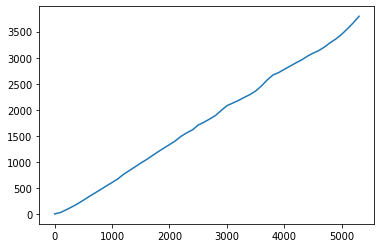

In [32]:
x = [i for i in range(1, min([len(set(mostPopular0)), len(set(mostPopular1))]), 100)]
y = []
for n in x:
    y.append(len(set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])))

plt.plot(x,y)